## Import packages and data

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import plotly.express as px

df = pd.read_csv('data.csv')
# df = pd.read_csv('df_all.csv')
df_w_genres = pd.read_csv('data_w_genres.csv')
# df_year = pd.read_csv('data_by_year.csv')
# df_by_genres = pd.read_csv('data_by_genres.csv')
# df_artist = pd.read_csv('data_by_artist.csv')


## Look at correlations

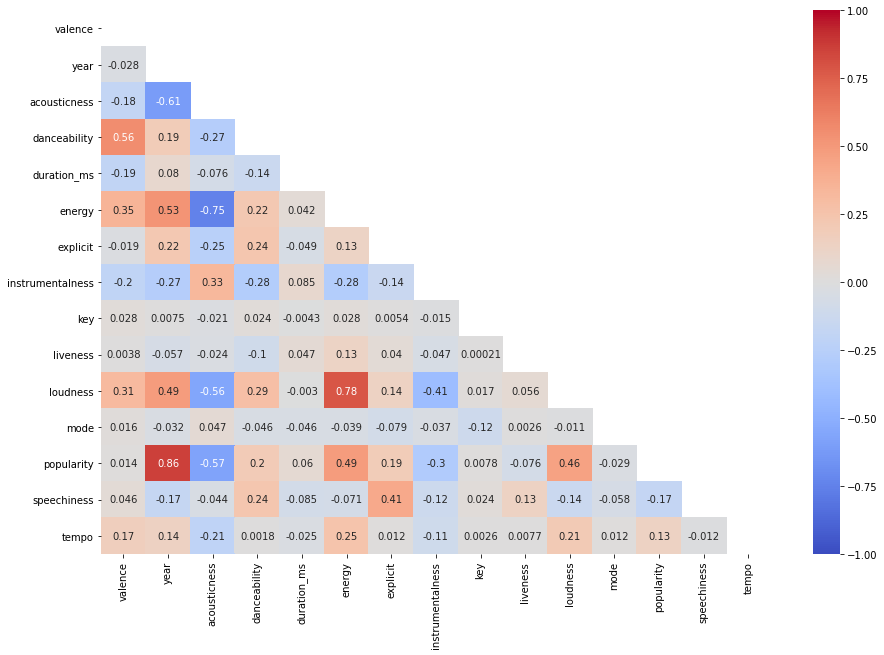

In [19]:
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(15, 10))
sns.heatmap(
    df.corr(),
    cmap='coolwarm',
    annot=True,
    mask=mask,
    vmin=-1.,
    vmax=1.
);

## Modify/simplify genres

In [20]:
print('len before: ', len(df_w_genres))
df_w_genres = df_w_genres[df_w_genres['genres'] !='[]']
print('len after: ', len(df_w_genres))

len before:  28680
len after:  18823


In [21]:
df_w_genres.reset_index(drop=True, inplace=True)
df_w_genres['genre_summary'] = df_w_genres['genres'].copy()
df_w_genres['genre_summary'] = df_w_genres['genres'].apply(lambda x: ast.literal_eval(x)[0].split(' ')[-1])

df_w_genres = df_w_genres[df_w_genres['genre_summary'] != 'music']
df_w_genres = df_w_genres[df_w_genres['genre_summary'] != 'band']
df_w_genres = df_w_genres[df_w_genres['genre_summary'] != 'corrido']
df_w_genres['genre_summary'] = df_w_genres['genre_summary'].replace(['hop'],'hip hop')
df_w_genres['genre_summary'] = df_w_genres['genre_summary'].replace(['standards'],'jazz')
df_w_genres['genre_summary'] = df_w_genres['genre_summary'].replace(['performance'],'classical')
df_w_genres['genre_summary'] = df_w_genres['genre_summary'].replace(['folk'],'folk music')
df_w_genres['genre_summary'] = df_w_genres['genre_summary'].replace(['tunes'],'show tunes')

values = df_w_genres['genre_summary'].value_counts()
df_w_genres['genre_summary_num'] = df_w_genres['genre_summary'].apply(lambda x: values[x])
pd.set_option('display.max_rows', 400)
df_w_genres = df_w_genres[df_w_genres['genre_summary_num'] > 300]
df_w_genres.drop(columns=['genres', 'genre_summary_num'], inplace=True)
df_w_genres.reset_index(inplace=True, drop=True)

In [22]:
pd.set_option('display.max_columns', None)
grouped = df_w_genres.groupby('genre_summary').aggregate(['mean'])
grouped.columns = grouped.columns.get_level_values(0)
grouped.reset_index(inplace=True)
grouped.head(1)

,genre_summary,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode,count
0,classical,0.914422,0.314066,329879.449456,0.171092,0.532464,0.177933,-20.35904,0.055543,102.273934,0.233001,19.027377,5.066038,0.850943,45.85283


## Visualize variance in musical attributes

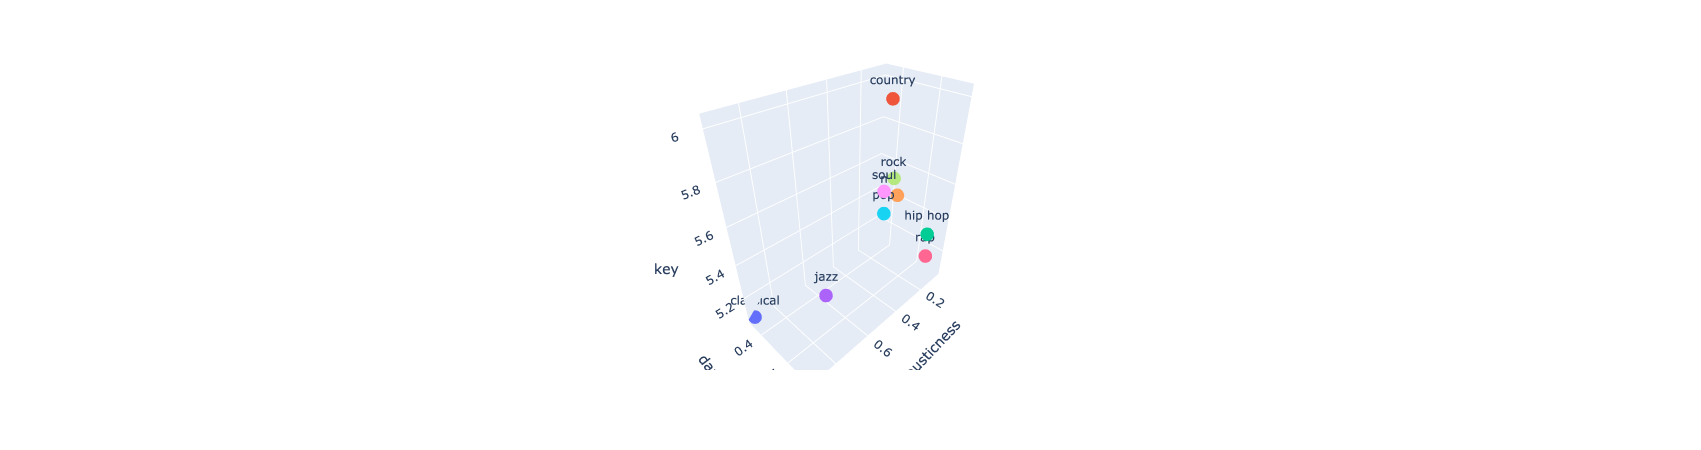

In [23]:
fig = px.scatter_3d(grouped, x='acousticness', y='danceability',  z='key',color='genre_summary', text='genre_summary')
fig.update_traces(textposition='top center')
fig.update_layout(showlegend=False)
fig.show()

## Preparing data for models

In [70]:
from sklearn.model_selection import train_test_split
X = df_w_genres[['acousticness', 'danceability', 'duration_ms', 'energy','instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'key', 'mode']]
# X = df_w_genres[['acousticness', 'instrumentalness', 'loudness', 'speechiness', 'energy', 'popularity', 'valence']]
# X = df_w_genres[['acousticness', 'danceability', 'duration_ms', 'loudness', 'speechiness', 'tempo', 'valence']]
y = df_w_genres['genre_summary']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=126)

In [71]:
# df['pop_bin'] = pd.cut(df['popularity'], 20)
# df['pop_bin'] = df['pop_bin'].apply(lambda x: str(x))
# X = df[['valence', 'acousticness','danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo']]
# y = df['pop_bin']
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=126)
# df['pop_bins']
# X = df[['valence', 'year', 'acousticness', 'danceability','duration_ms', 'energy', 'explicit', 'instrumentalness', 'key','liveness', 'loudness', 'mode', 'speechiness', 'tempo']]
# # y = pd.cut(df['popularity'], bins=20, retbins=True)
# y = df['popularity']
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=126)

In [72]:
X.shape

(7536, 12)

In [73]:
y.shape

(7536,)

In [74]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [75]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures()
X_train_expanded = pf.fit_transform(X_train)
X_test_expanded = pf.transform(X_test)

## Dummy (Baseline)

In [76]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.dummy import DummyClassifier
dc = DummyClassifier()
dc.fit(X_train_scaled, y_train)
print('Accuracy score for dummy model with unprocessed values: ', dc.score(X_test_scaled, y_test))

Accuracy score for dummy model with unprocessed values:  0.16348195329087048


In [77]:
# Balanced accuracy
from sklearn.metrics import balanced_accuracy_score
print('Balanced accuracy score for dummy model with unprocessed values: ', balanced_accuracy_score(y_test, dc.predict(X_test)))

Balanced accuracy score for dummy model with unprocessed values:  0.1118760653425143


## Logistic Regression

### Raw Values

In [78]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=10_000)
logreg.fit(X_train, y_train)
preds_logreg_raw = logreg.predict(X_test)
print('Accuracy score for logstic regression with unprocessed values: ', logreg.score(X_test, y_test))

Accuracy score for logstic regression with unprocessed values:  0.2914012738853503


#### Comparing predictions

In [79]:
# Predicted genres
(unique, counts) = np.unique(preds_logreg_raw, return_counts=True)
predicted_genres = np.asarray((unique, counts))
print('Predicted genres are: \n')
for i in range(0, len(predicted_genres[0])):
    print(predicted_genres[0][i].title() + ' - ' + str(predicted_genres[1][i]))

Predicted genres are: 

Classical - 53
Pop - 1410
Rock - 421


In [80]:
# Actual genres
(unique, counts) = np.unique(y_test, return_counts=True)
actual_genres = np.asarray((unique, counts))
print('Actual genres are: \n')
for i in range(0, len(actual_genres[0])):
    print(actual_genres[0][i].title() + ' - ' + str(actual_genres[1][i]))

Actual genres are: 

Classical - 131
Country - 121
Hip Hop - 181
Jazz - 192
Metal - 104
Pop - 516
Rap - 166
Rock - 390
Soul - 83


### Scaled Values

In [81]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=10_000)
logreg.fit(X_train_scaled, y_train)
preds_scaled = logreg.predict(X_test_scaled)

print('Accuracy score for logstic regression with scaled values: ', logreg.score(X_test_scaled, y_test))

Accuracy score for logstic regression with scaled values:  0.48089171974522293


#### Comparing predictions

In [82]:
# Predicted values
(unique, counts) = np.unique(preds_scaled, return_counts=True)
predicted_genres = np.asarray((unique, counts))
print('Predicted genres are: \n')
for i in range(0, len(predicted_genres[0])):
    print(predicted_genres[0][i].title() + ' - ' + str(predicted_genres[1][i]))

Predicted genres are: 

Classical - 159
Country - 1
Hip Hop - 167
Jazz - 81
Metal - 96
Pop - 884
Rap - 115
Rock - 378
Soul - 3


In [83]:
# Actual values
(unique, counts) = np.unique(y, return_counts=True)
actual_genres = np.asarray((unique, counts))
print('Actual genres are: \n')
for i in range(0, len(actual_genres[0])):
    print(actual_genres[0][i].title() + ' - ' + str(actual_genres[1][i]))

Actual genres are: 

Classical - 530
Country - 532
Hip Hop - 735
Jazz - 633
Metal - 460
Pop - 2128
Rap - 673
Rock - 1523
Soul - 322


### Polynomial Features

In [84]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=10_000)
logreg.fit(X_train_expanded, y_train)
# preds_scaled = logreg.predict(X_test_expanded)
print('Accuracy score for logstic regression with scaled values: ', logreg.score(X_test_expanded, y_test))

Accuracy score for logstic regression with scaled values:  0.2908704883227176


### Grid Search

In [85]:
from sklearn.model_selection import GridSearchCV
params = {'C': [.001, .01, .1, 1, 10, 100, 1_000, 10_000], "penalty":["l1","l2"]}
gs_logreg = GridSearchCV(LogisticRegression(), params, n_jobs=-1)
gs_logreg.fit(X_train_scaled, y_train)
print('Accuracy score for logstic regression with scaled values: ', gs_logreg.score(X_test_scaled, y_test))

Accuracy score for logstic regression with scaled values:  0.48036093418259024


In [86]:
best_paramters = gs_logreg.best_params_
print('Optimal params are:')
for key in best_paramters:
    print(key + ': ' + str(best_paramters[key]))

Optimal params are:
C: 10
penalty: l2


# KNN

### Raw

In [87]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
knn = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)
knn.fit(X_train, y_train)
print('Accuracy score for KNN with unprocessed values: ', knn.score(X_test, y_test))

Accuracy score for KNN with unprocessed values:  0.20222929936305734


### Scaled

In [88]:
knn = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)
knn.fit(X_train_scaled, y_train)
print('Accuracy score for KNN with scaled values: ', knn.score(X_test_scaled, y_test))

Accuracy score for KNN with scaled values:  0.4538216560509554


### Polynomial Features

In [89]:
knn = KNeighborsClassifier(n_neighbors=4, n_jobs=-1)
knn.fit(X_train_expanded, y_train)
print('Accuracy score for KNN with scaled values: ', knn.score(X_test_expanded, y_test))

Accuracy score for KNN with scaled values:  0.19851380042462846


### Grid Search

In [90]:
from sklearn.model_selection import GridSearchCV
params = {'n_neighbors': range(25, 80), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']}
gs = GridSearchCV(KNeighborsClassifier(), params, n_jobs=-1)
gs.fit(X_train_scaled, y_train)

print('Accuracy score for Grid Search with KNN (scaled values): ', gs.score(X_test_scaled, y_test))

Accuracy score for Grid Search with KNN (scaled values):  0.5084925690021231


In [91]:
best_paramters = gs.best_params_
print('Optimal params are:')
for key in best_paramters:
    print(key + ': ' + str(best_paramters[key]))

Optimal params are:
metric: manhattan
n_neighbors: 28
weights: distance


# Decision Tree

### Raw

In [92]:
from sklearn.tree import DecisionTreeClassifier
tree_raw = DecisionTreeClassifier(max_depth=9)
tree_raw.fit(X_train, y_train)
tree_raw.score(X_test, y_test)

0.46602972399150744

### Scaled

In [93]:
tree_scaled = DecisionTreeClassifier(max_depth=3)
tree_scaled.fit(X_train_scaled, y_train)
tree_scaled.score(X_test_scaled, y_test)

0.37048832271762205

### Polynomial Features

In [94]:
tree_pf = DecisionTreeClassifier(max_depth=9)
tree_pf.fit(X_train_expanded, y_train)
tree_pf.score(X_test_expanded, y_test)

0.4681528662420382

### Grid Search

In [95]:
from sklearn.model_selection import GridSearchCV
params = {'max_depth': range(1, 20)}
gs = GridSearchCV(DecisionTreeClassifier(), params, n_jobs=-1)
gs.fit(X_train_expanded, y_train)

print('Accuracy score for Grid Search with DecisionTreeClassifier (scaled values): ', gs.score(X_test_expanded, y_test))

Accuracy score for Grid Search with DecisionTreeClassifier (scaled values):  0.4708067940552017


In [96]:
best_paramters = gs.best_params_
print('Optimal params are:')
for key in best_paramters:
    print(key + ': ' + str(best_paramters[key]))

Optimal params are:
max_depth: 8


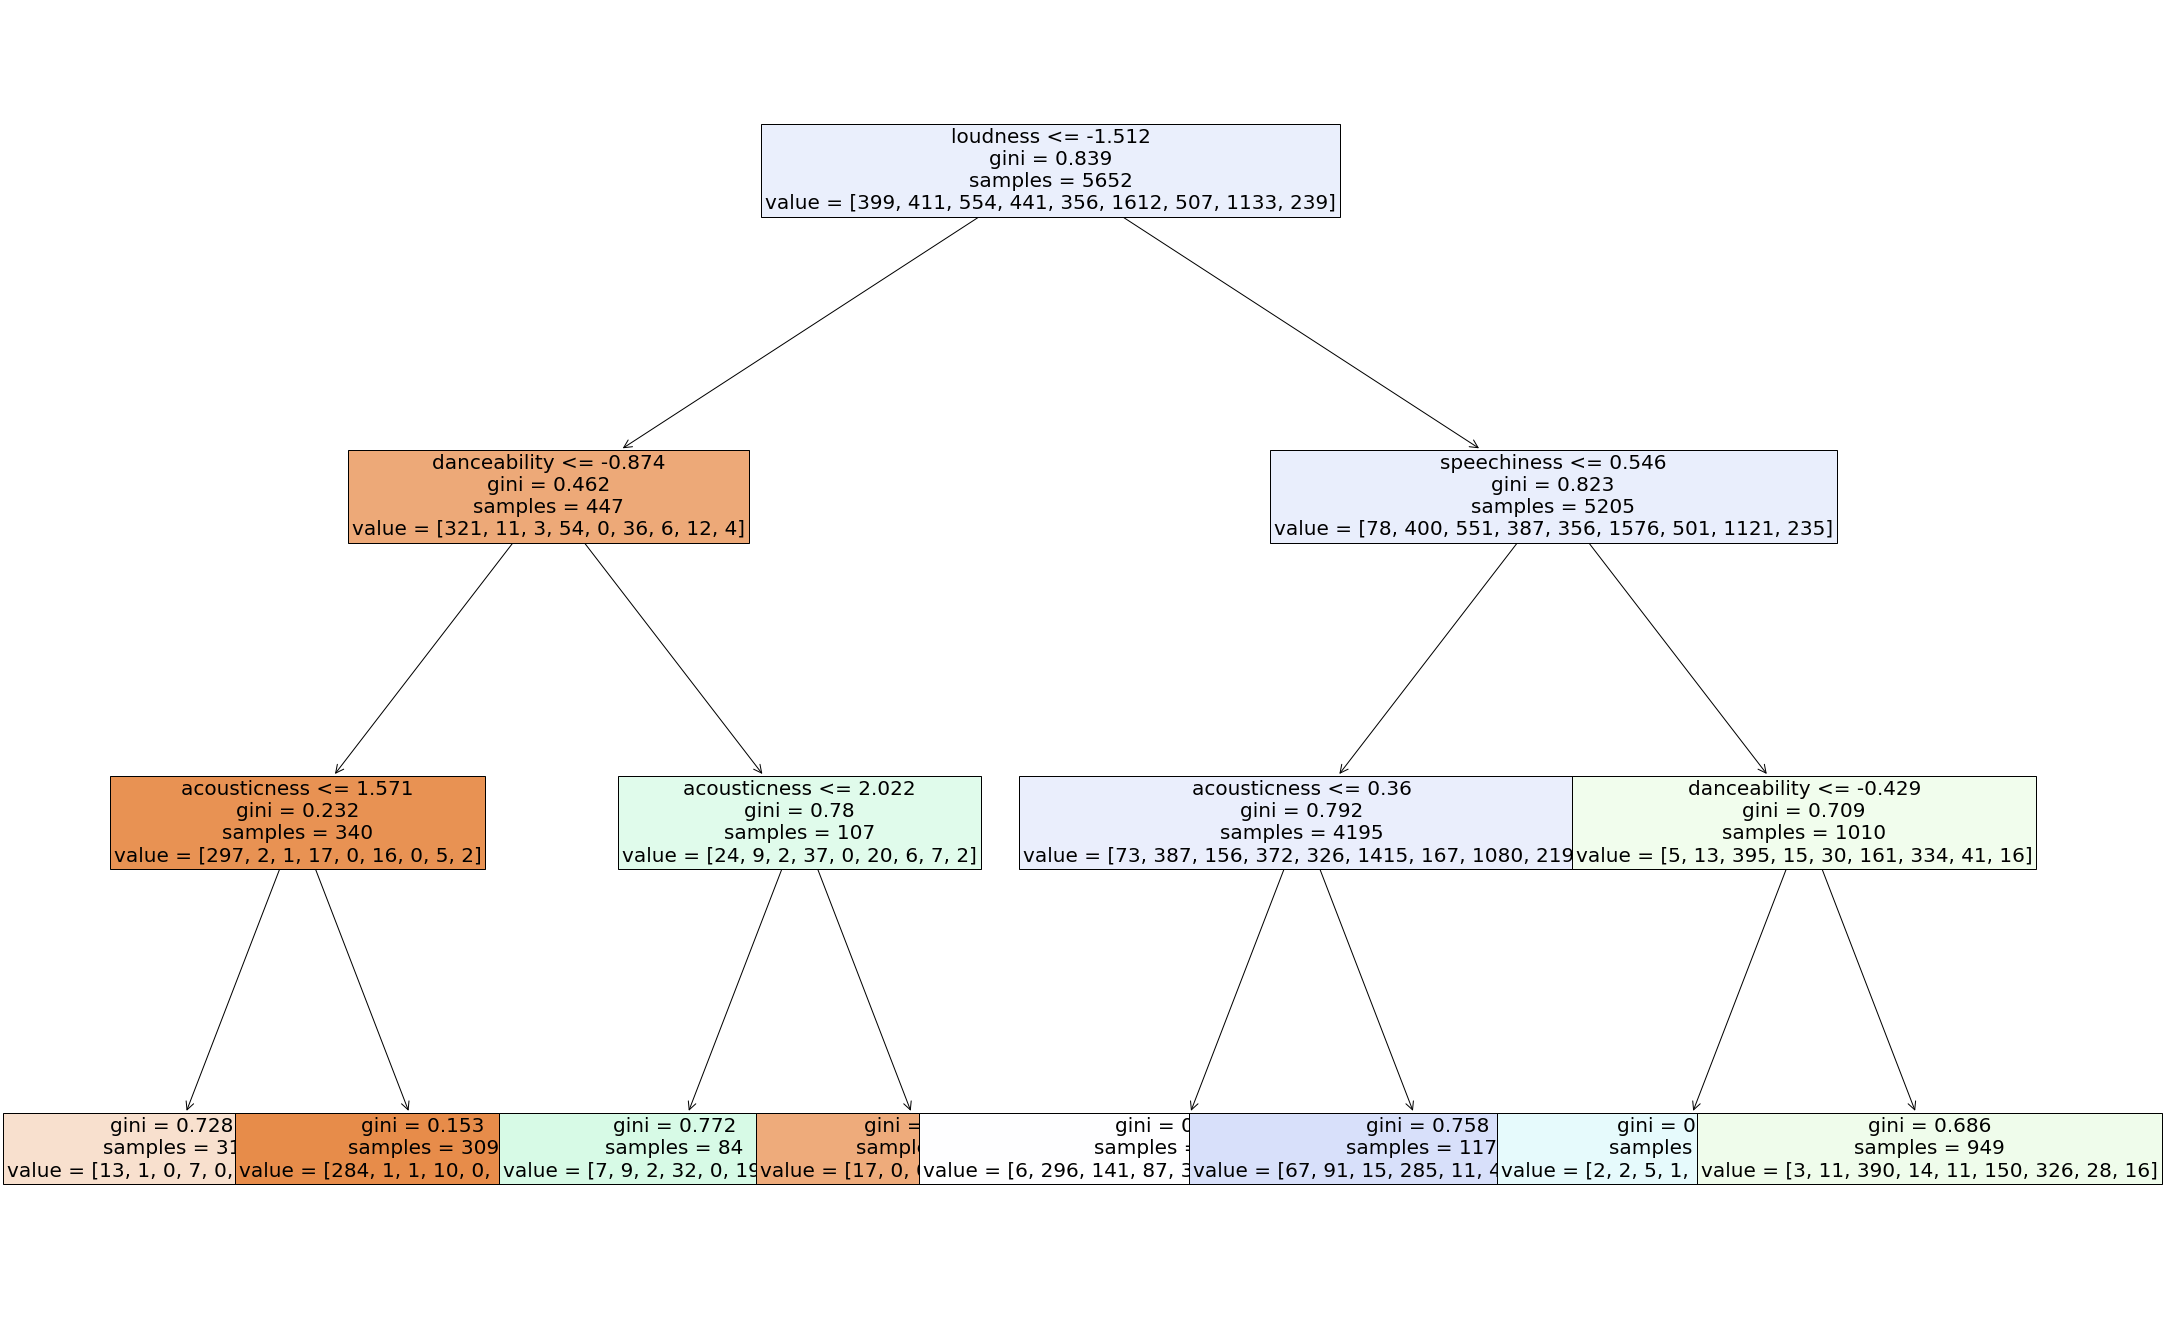

In [97]:
from sklearn.tree import plot_tree
plt.figure(figsize=(36, 24))
plot_tree(tree_scaled, filled=True, fontsize=20, feature_names=X.columns);

## So we've hit an upper limit on predicting genre, with about 50% accuracy